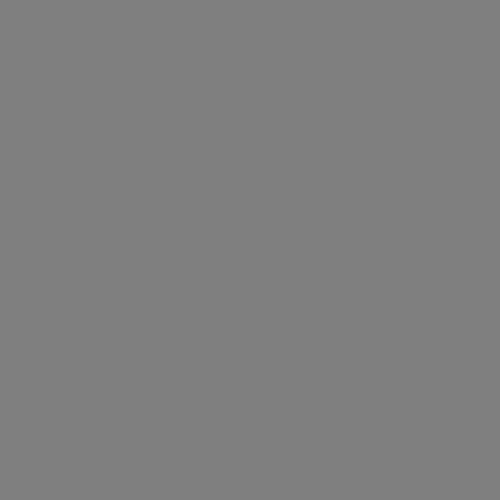

In [1]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

def MakeImage(a, fmt='jpeg', rng=[0,1]):
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  return Image(data=f.getvalue())

def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  Img = MakeImage(a, fmt, rng)
  clear_output(wait = True)
  display(Img)

sess = tf.InteractiveSession()

def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_h = make_kernel([[0.0, 1.0, 0.0],
                           [1.0, -4., 1.0],
                           [0.0, 1.0, 0.0]])
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

N = 500

# Initial Conditions

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

DisplayArray(u_init, rng=[-0.1, 0.1])

# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

# Initialize state to initial conditions
tf.global_variables_initializer().run()

In [2]:
p = 0

# Prepare positions of phased array sources
PhaseDelay = 3 #phase delay between elements in eps time units
Sources = []
NumSources = 64
DistanceBetweenSources = 2
BaseY = 410
BaseX = N/2 - NumSources*DistanceBetweenSources/2
for i in range(NumSources):
    Sources.append((BaseY,BaseX+i*DistanceBetweenSources))

# Run 10000 steps of PDE
for i in range(10000):
  # Step simulation
  step.run({eps: 0.05, damping: 0.01})
    
  # At every time step,ovie check if a new source must be added
  if i%PhaseDelay == 0 and p<NumSources-1 :
    p = p + 1
    Ucurrent = U.eval(),
    UasArray= Ucurrent[0]
    UasArray[Sources[p][0],Sources[p][1]]=1
    nstep = tf.group(U.assign(UasArray))
    nstep.run()
  
  DisplayArray(U.eval(), rng=[-0.1, 0.1])

KeyboardInterrupt: 